Test accuracy: 0.975


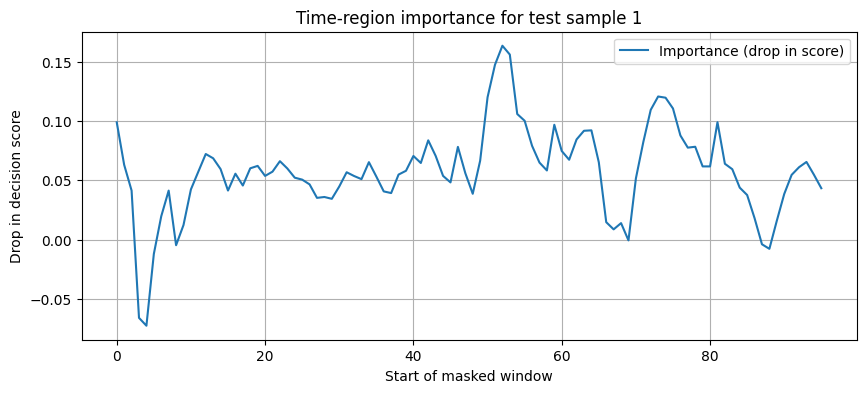

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score
from aeon.datasets import load_basic_motions
from aeon.transformations.collection.convolution_based import Rocket

# Step 1: Load the dataset
X_train, y_train = load_basic_motions(split="train", return_type="numpy3d")
X_test, y_test = load_basic_motions(split="test", return_type="numpy3d")

# Step 2: Fit ROCKET transformer
rocket = Rocket(n_kernels=10_000, random_state=42)
rocket.fit(X_train)
X_train_trans = rocket.transform(X_train)
X_test_trans = rocket.transform(X_test)

# Step 3: Train a classifier
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_trans, y_train)
print("Test accuracy:", accuracy_score(y_test, clf.predict(X_test_trans)))

# Step 4: Define perturbation-based importance function
def mask_segment(X, start, length, fill_value=0.0):
    """Mask a time window across all channels"""
    X_masked = X.copy()
    X_masked[:, start:start + length] = fill_value
    return X_masked

def sliding_window_importance(sample, rocket, clf, window_size=5):
    """
    Estimate importance of each time window by how much
    it affects classification confidence when masked.
    """
    orig_feat = rocket.transform(sample[None, ...])
    orig_proba = clf.decision_function(orig_feat)[0]
    true_class = clf.predict(orig_feat)[0]

    importances = []
    for start in range(sample.shape[1] - window_size + 1):
        masked = sample.copy()
        masked[:, start:start+window_size] = 0.0  # zero-out across channels
        masked_feat = rocket.transform(masked[None, ...])
        masked_score = clf.decision_function(masked_feat)[0]

        # Score drop for the predicted class
        class_index = list(clf.classes_).index(true_class)
        drop = orig_proba[class_index] - masked_score[class_index]
        importances.append(drop)

    return np.array(importances)

# Step 5: Run on one test sample
i = 1  # test sample index
sample = X_test[i]  # shape (channels, time)

importance = sliding_window_importance(sample, rocket, clf, window_size=5)

# Step 6: Plot importance
plt.figure(figsize=(10, 4))
plt.plot(importance, label="Importance (drop in score)")
plt.title(f"Time-region importance for test sample {i}")
plt.xlabel("Start of masked window")
plt.ylabel("Drop in decision score")
plt.grid(True)
plt.legend()
plt.show()


In [22]:
sample = X_test[0]

In [24]:
sample.shape

(6, 100)

In [25]:
orig_feat = rocket.transform(sample[None, ...])

In [29]:
orig_feat.shape

(1, 20000)

Test accuracy: 0.975


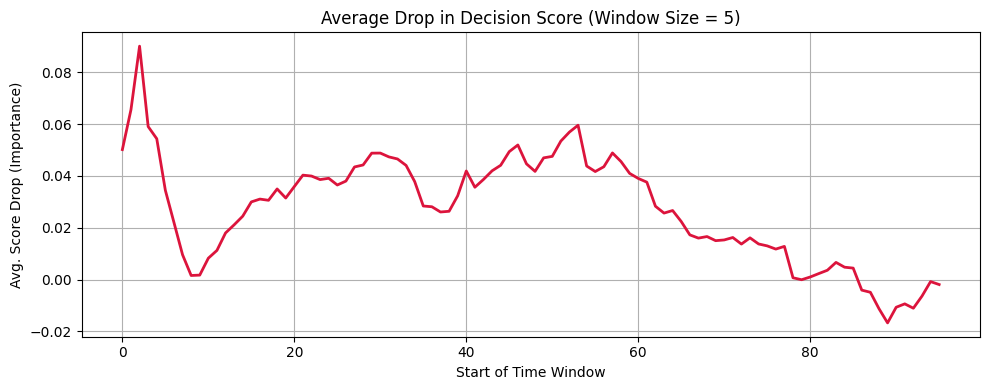

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score
from aeon.datasets import load_basic_motions
from aeon.transformations.collection.convolution_based import Rocket

# Step 1: Load dataset
X_train, y_train = load_basic_motions(split="train", return_type="numpy3d")
X_test, y_test = load_basic_motions(split="test", return_type="numpy3d")

# Step 2: Train ROCKET + classifier
rocket = Rocket(n_kernels=10000, random_state=42)
rocket.fit(X_train)
X_train_trans = rocket.transform(X_train)
X_test_trans = rocket.transform(X_test)

clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_trans, y_train)
print("Test accuracy:", accuracy_score(y_test, clf.predict(X_test_trans)))

# Step 3: Perturbation function (single sample)
def sliding_window_importance(sample, rocket, clf, window_size=5):
    orig_feat = rocket.transform(sample[None, ...])
    orig_proba = clf.decision_function(orig_feat)[0]
    true_class = clf.predict(orig_feat)[0]
    class_index = list(clf.classes_).index(true_class)

    importance = []
    for start in range(sample.shape[1] - window_size + 1):
        perturbed = sample.copy()
        perturbed[:, start:start + window_size] = 0.0
        pert_feat = rocket.transform(perturbed[None, ...])
        pert_proba = clf.decision_function(pert_feat)[0]
        drop = orig_proba[class_index] - pert_proba[class_index]
        importance.append(drop)
    return np.array(importance)

# Step 4: Loop over all test samples
window_size = 5
n_windows = X_test.shape[2] - window_size + 1
all_importances = []

for i in range(len(X_test)):
    imp = sliding_window_importance(X_test[i], rocket, clf, window_size=window_size)
    all_importances.append(imp)

# Step 5: Average across samples
avg_importance = np.mean(all_importances, axis=0)

# Step 6: Plot average importance curve
plt.figure(figsize=(10, 4))
plt.plot(avg_importance, color="crimson", lw=2)
plt.title(f"Average Drop in Decision Score (Window Size = {window_size})")
plt.xlabel("Start of Time Window")
plt.ylabel("Avg. Score Drop (Importance)")
plt.grid(True)
plt.tight_layout()
plt.show()
